# Creating a Manually Labeled Dataset

## 1. Objective

### 1.1 Why this matter?


### 1.2 What is the output of this notebook?


### 1.3 Key Takeaway and actions


***
## 2. Setup

Run the below code to import all the necessary libraries and data to run the following codes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection, LineCollection

import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

from src.RefriPlot import *
from src.RefriDataHelper import *

DEFAULT_COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'] #Proposed colors, in case temp is not plotted


#Allows generated charts to be interactive
%matplotlib widget

#Read preprocessed CSVs
csv_files = RefriDataHelper_ReadParsedLogs()

#Store the name of the temp columns for further calculations
TEMP_COL_NAMES = list(csv_files.values())[0].columns[2:]

***
## 3. Manual Inspection 


### 3.1 Logs Distribution

In Order to obtain some high level summary of the temperature logs, below is a histogram of some basic statistical information of each sensors troughout all the logs on the dataset:
- Mean
- Standard Deviation
- Min and Max
- 25%(Q1), 50%(Q2) and 75%(Q3) percentiles (or quartiles). In our case it for example, a log that has RC_25% at 0°C means that 25% of it's values are below 0°C

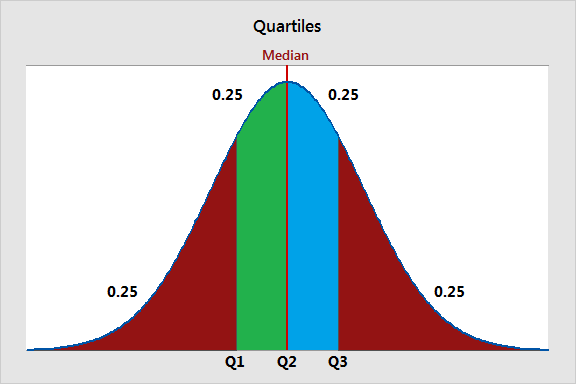

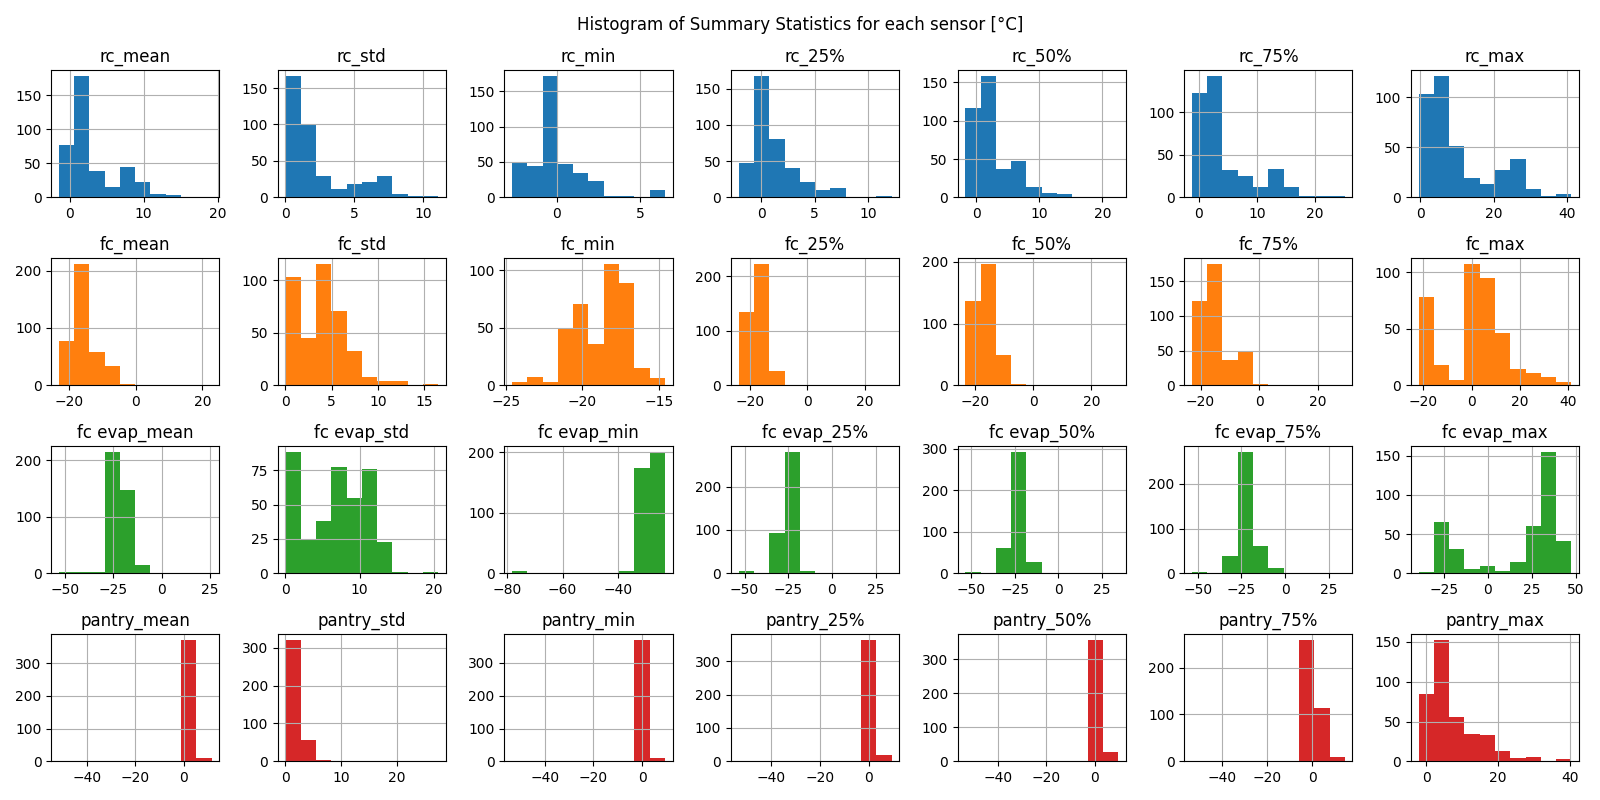

In [2]:
# Use describe method to get the overall statistics of each collumn for each log
sensors_summary = []
for log_id,log_name in enumerate(csv_files):
    sensors_summary.append([log_name])
    for sensor_name in TEMP_COL_NAMES:
        sensors_summary[log_id].extend(csv_files[log_name][sensor_name].describe().to_list())

#Create the name of the columns, which will be SENSOR_NAME + Statistic name, e.g: FC Mean, FC Max, ... RC Mean, RC Max, ...
summary_cols = csv_files[log_name][sensor_name].describe().index.to_list()

col_names = ['Log Name']
for sensor_name in TEMP_COL_NAMES:
    col_names.extend([sensor_name + '_' + s for s in summary_cols])

#Create a dataframe containing all the sensors summary by log
logs_summary = pd.DataFrame(sensors_summary,columns=col_names)
logs_summary.to_csv("../Data/Pre_Processed/Summarized Statistics of Temperatures.csv")


#Plot a histogram of each sensor
summary_cols_to_plot = summary_cols[1:] #Start by 1 to not plot the count column
fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(len(TEMP_COL_NAMES),len(summary_cols_to_plot))    

for sensor_id,sensor_name in enumerate(TEMP_COL_NAMES):
    for col_id,col_name in enumerate(summary_cols_to_plot):
            ax = fig.add_subplot(gs[sensor_id, col_id])
            logs_summary.hist(column=sensor_name+"_"+col_name,ax=ax,color=DEFAULT_COLORS[sensor_id])

fig.suptitle("Histogram of Summary Statistics for each sensor [°C]")
plt.tight_layout()
plt.show()

A couple interesting things can be observed by those charts:
1. There are 2 logs of Pantry Temperature with mean around -10°C (potential damper stuck open) and 11 logs of Pantry Temperature with average around 10°C (potential damper stuck close)

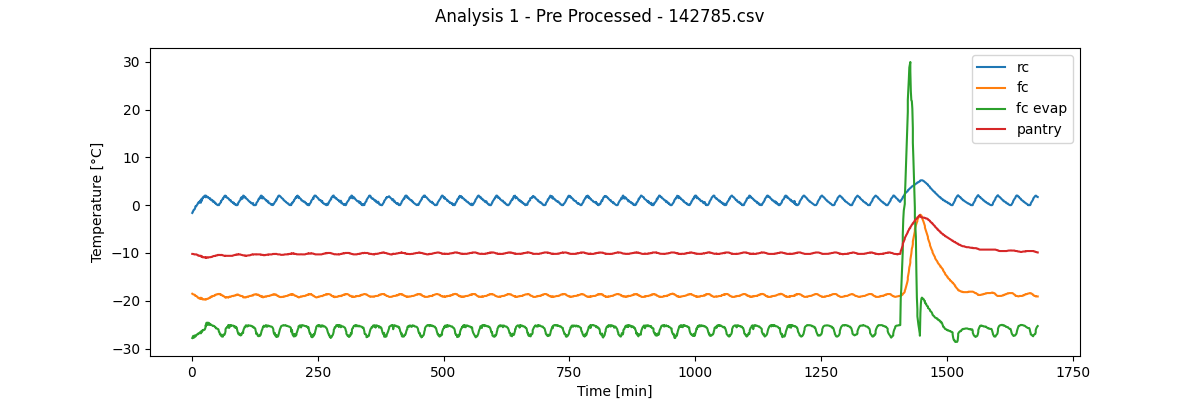

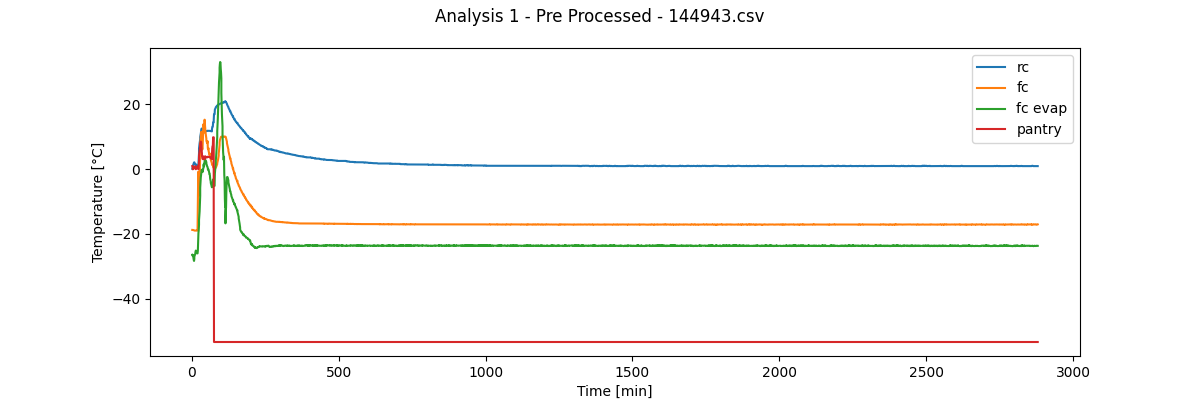

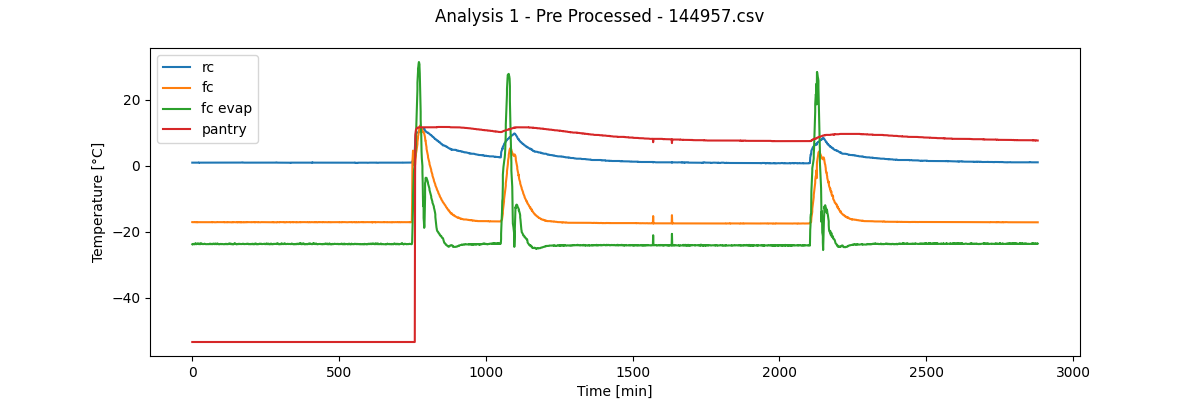

In [4]:
#Create a list of the logs that are ok. For now considering all of them ok
Logs_Manual_Label = {}
for log_to_analyze in csv_files:
    Logs_Manual_Label[log_to_analyze] = "UNKNONW"



analysis1 = logs_summary[logs_summary['pantry_mean'] < -5]['Log Name']

for log_to_analyze in analysis1:
    RefriPlot_PlotTemperature(csv_files[log_to_analyze],"Analysis 1 - " + log_to_analyze)

Logs_Manual_Label["Pre Processed - 142785.csv"] = "FAULT - Damper"
Logs_Manual_Label["Pre Processed - 144943.csv"] = "BAD"
Logs_Manual_Label["Pre Processed - 144957.csv"] = "BAD"

2. There is 1 Log of FC Evap average at 25°C, potential bad log where the product was not ON, since this temperature is way too hot to be an FC Evap (probably not even compressor ON)

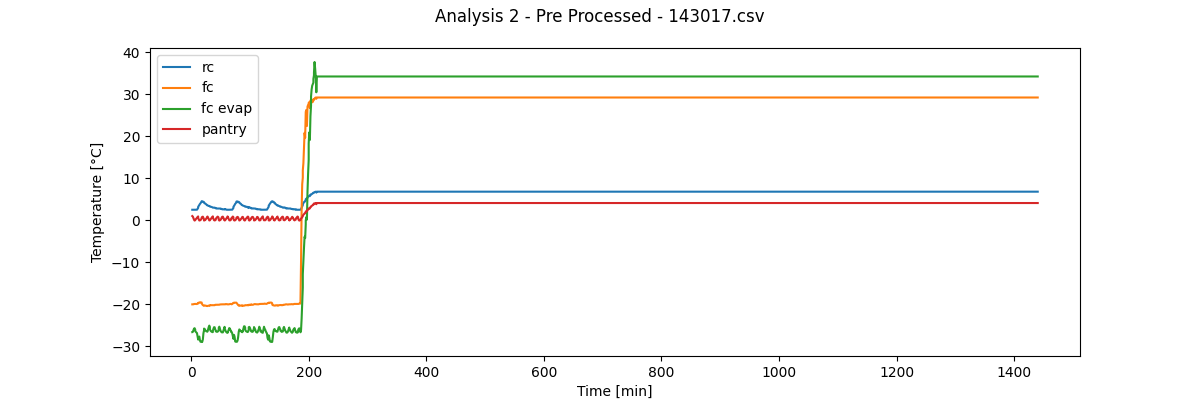

In [5]:
analysis2 = logs_summary[logs_summary['fc evap_mean'] > 10]['Log Name']

for log_to_analyze in analysis2:
    RefriPlot_PlotTemperature(csv_files[log_to_analyze],"Analysis 2 - " + log_to_analyze)

Logs_Manual_Label["Pre Processed - 143017.csv"] = "BAD"

3. There are 5 Logs of FC Evap min temperature below -50, which should indicate FC Evap Sensor in Failure, since usually those temperatures are not reached.

This point actually caught a lot the attention, since in theory the software should not even allow temperatures colder than -53.44°C according to the SettingFile

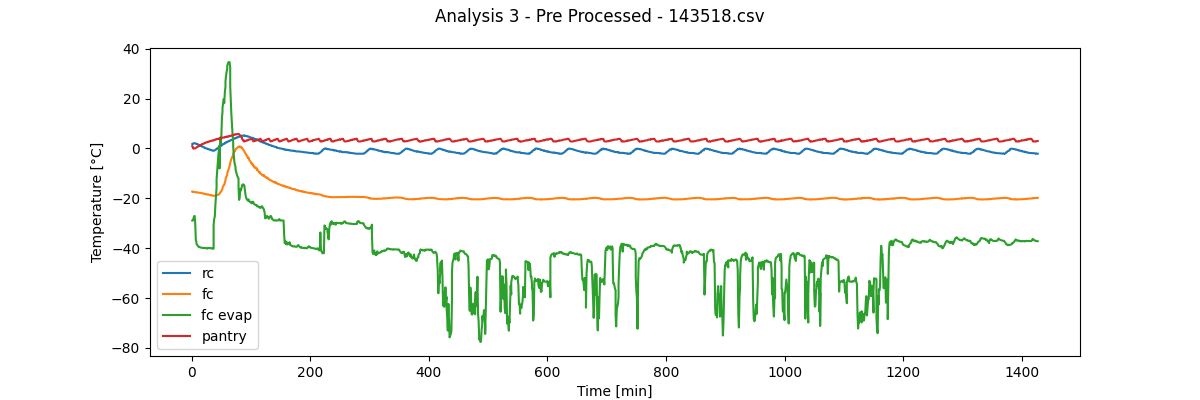

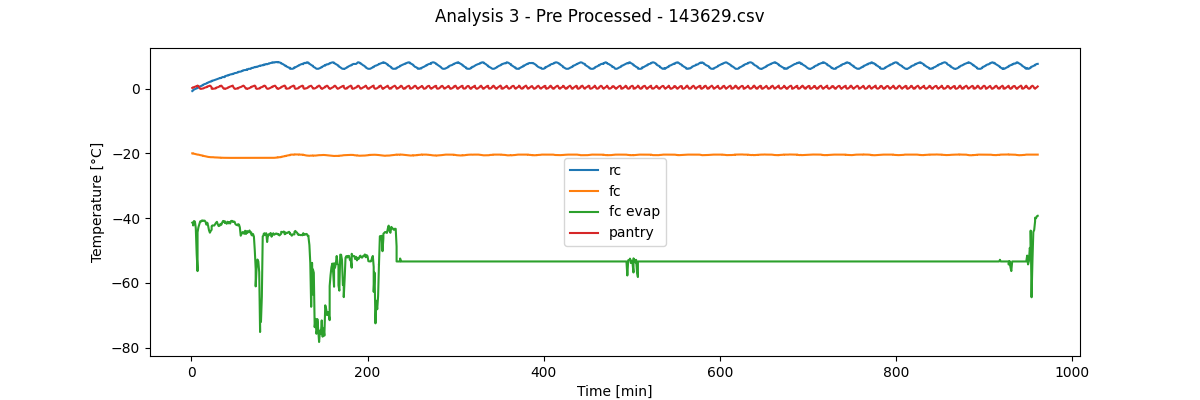

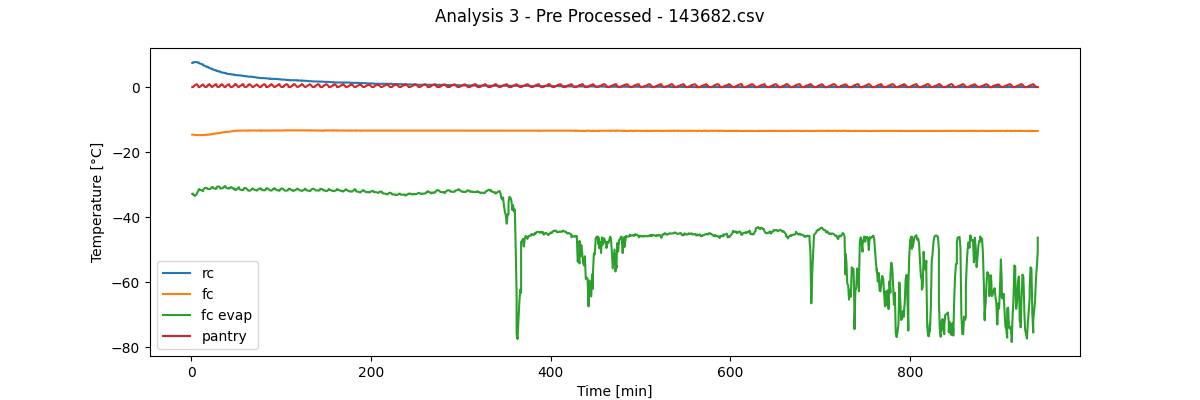

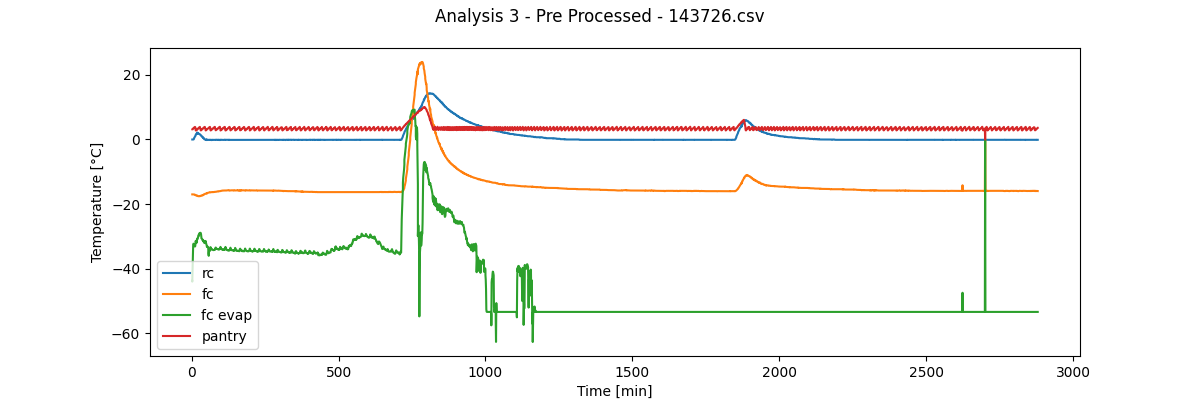

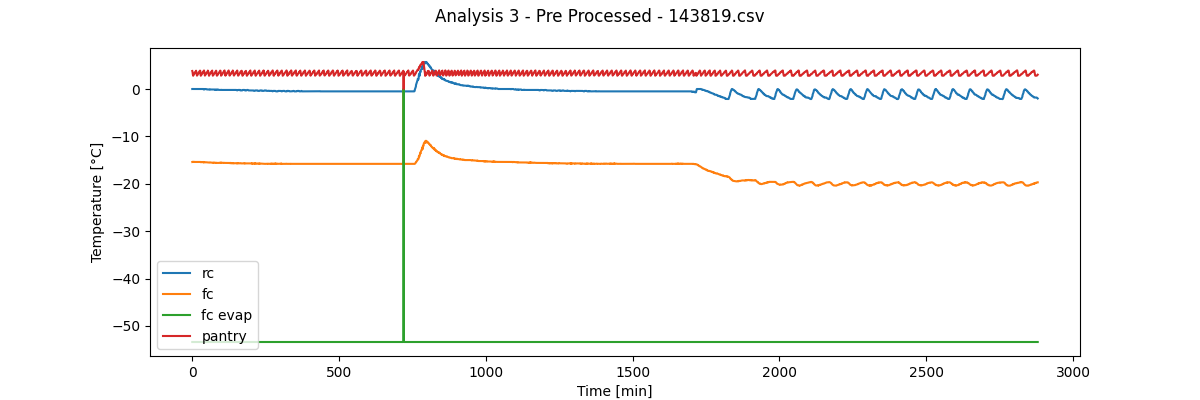

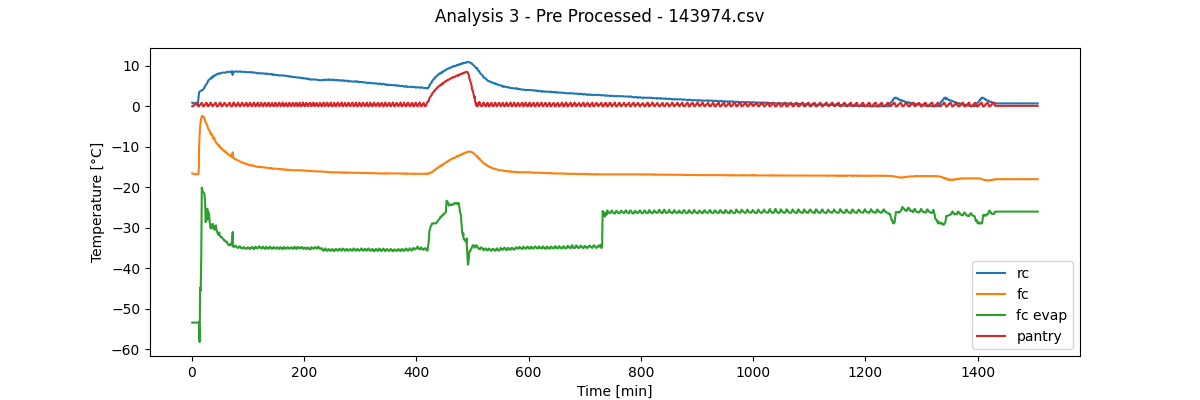

In [6]:
analysis3 = logs_summary[logs_summary['fc evap_min'] < -50]['Log Name']

for log_to_analyze in analysis3:
    RefriPlot_PlotTemperature(csv_files[log_to_analyze],"Analysis 3 - " + log_to_analyze)
    Logs_Manual_Label[log_to_analyze] = "BAD"

4. Some logs of RC mean temperature above 9°C, which could indicate a bad log or damper in failure

But as it will be observed, all those logs are fine, but they were all logs that seemed to be of door opening

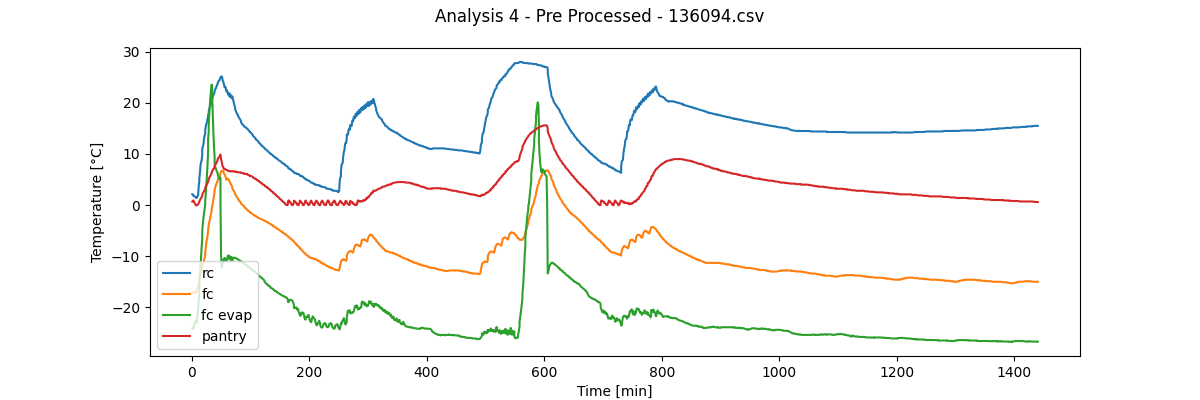

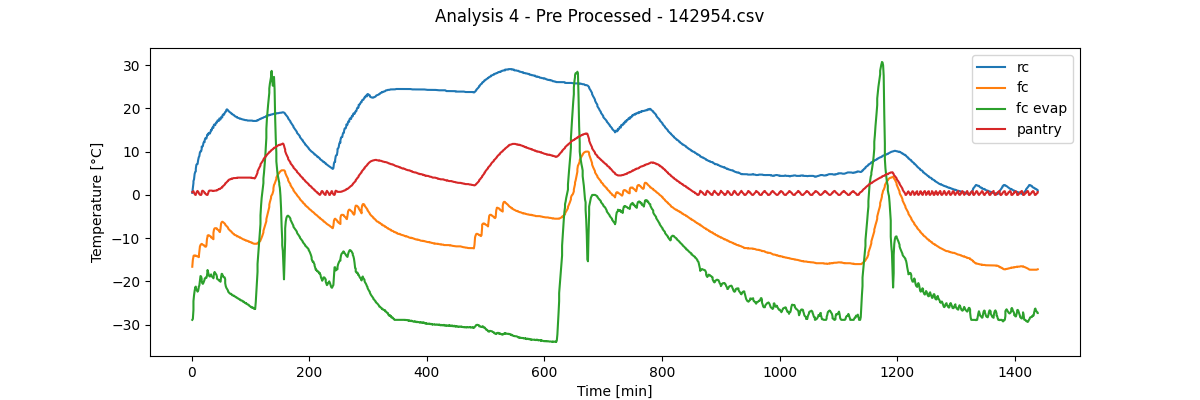

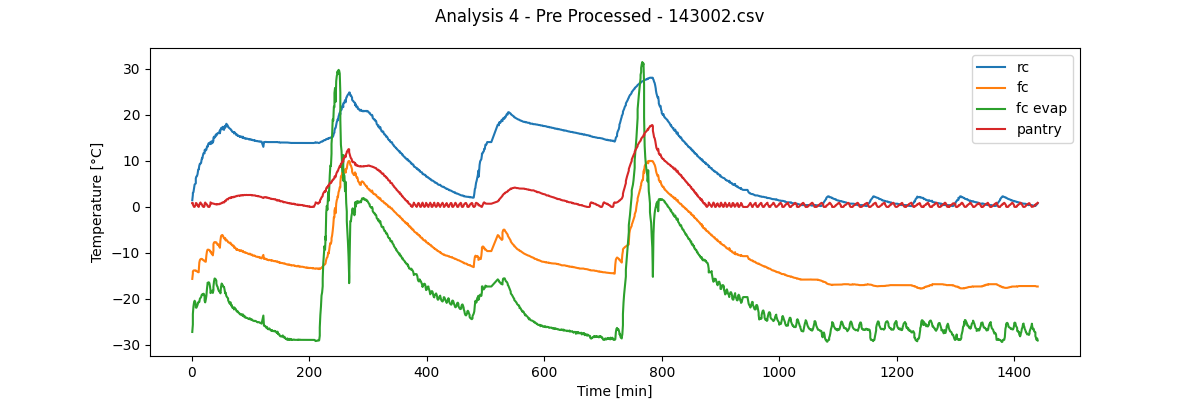

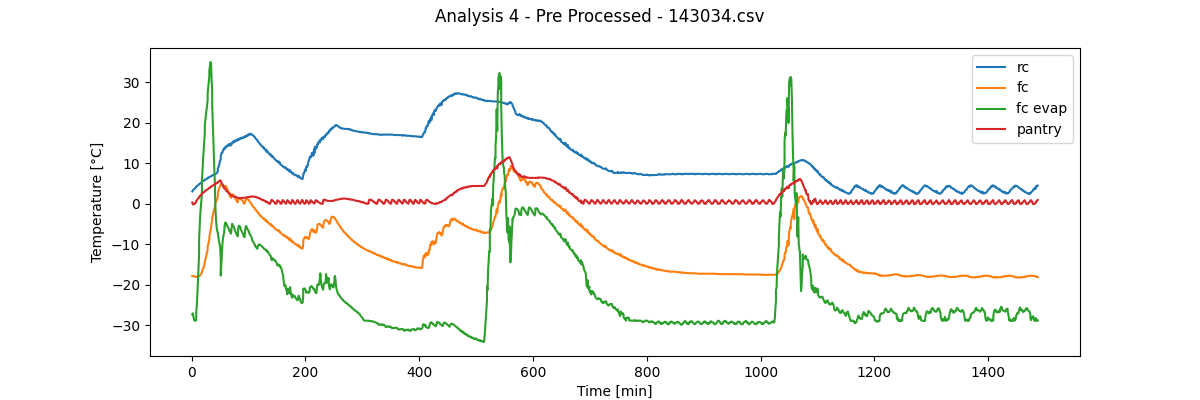

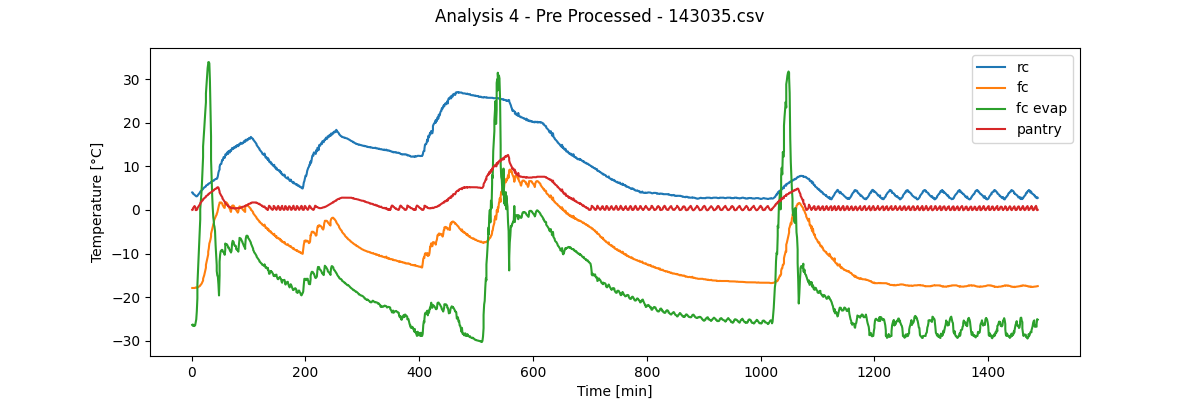

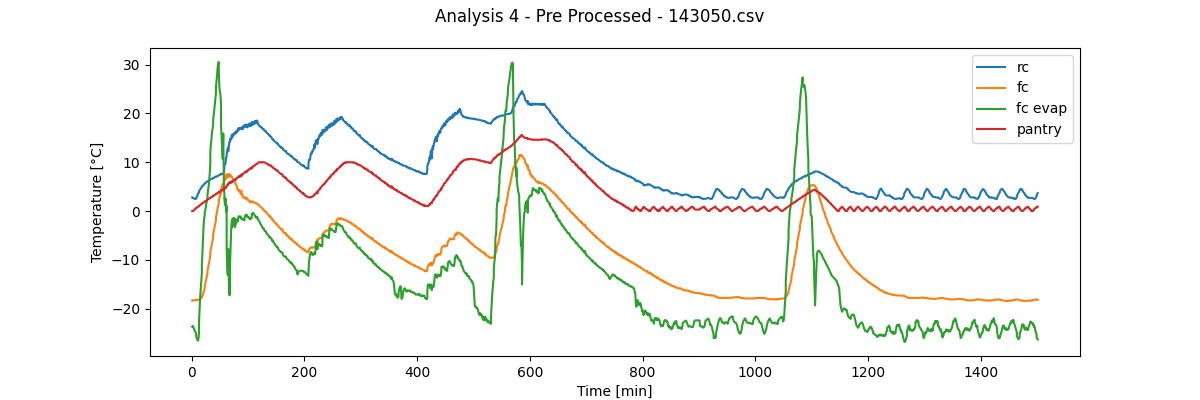

c:\Users\GRANDJ3\Desktop\dev\Diagnostics\AppliedML-Refrigerator_Fault_Detection\Notebooks\src\RefriPlot.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(12, 4))


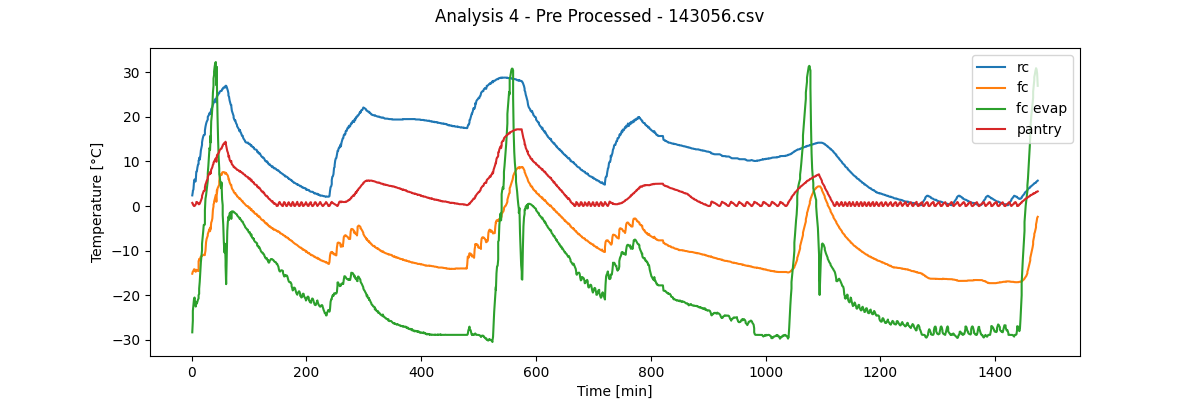

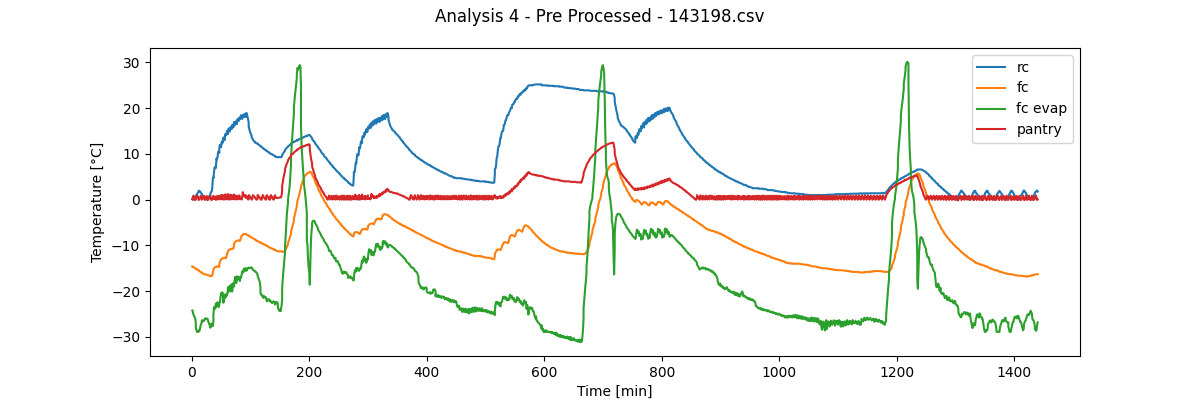

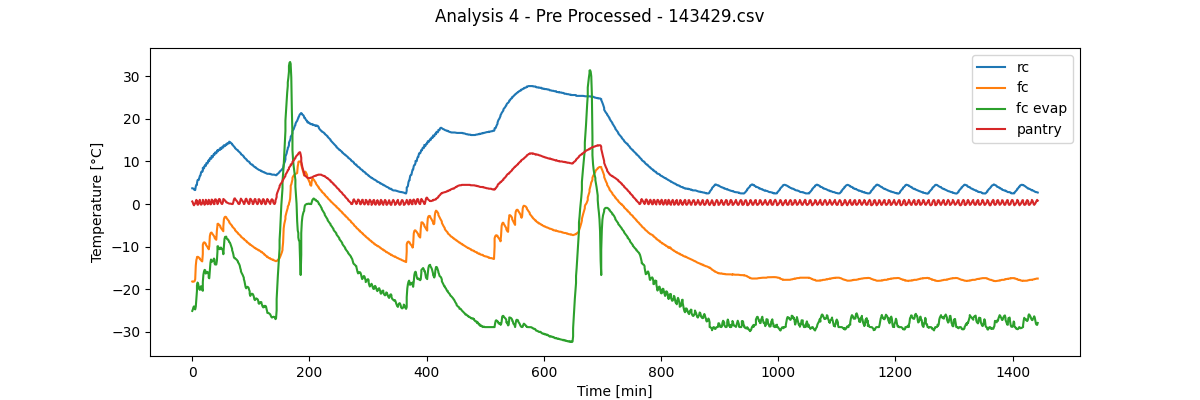

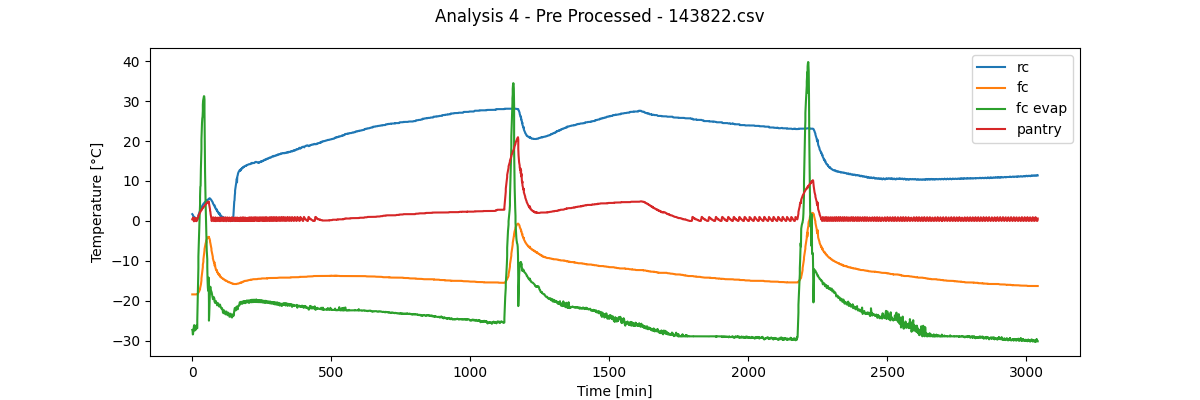

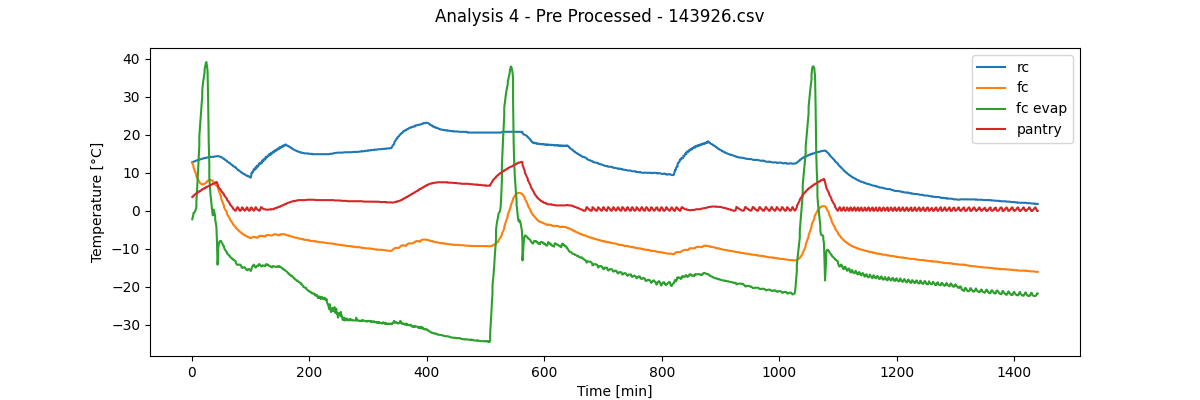

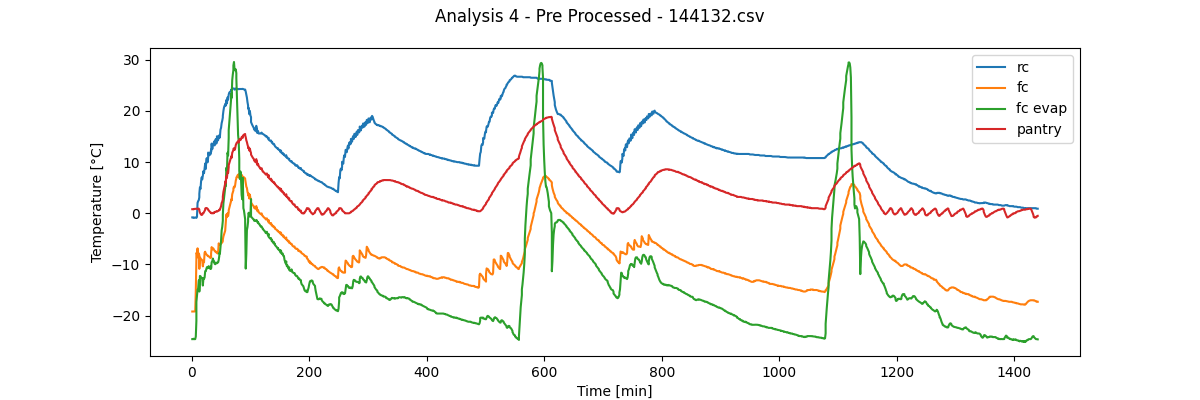

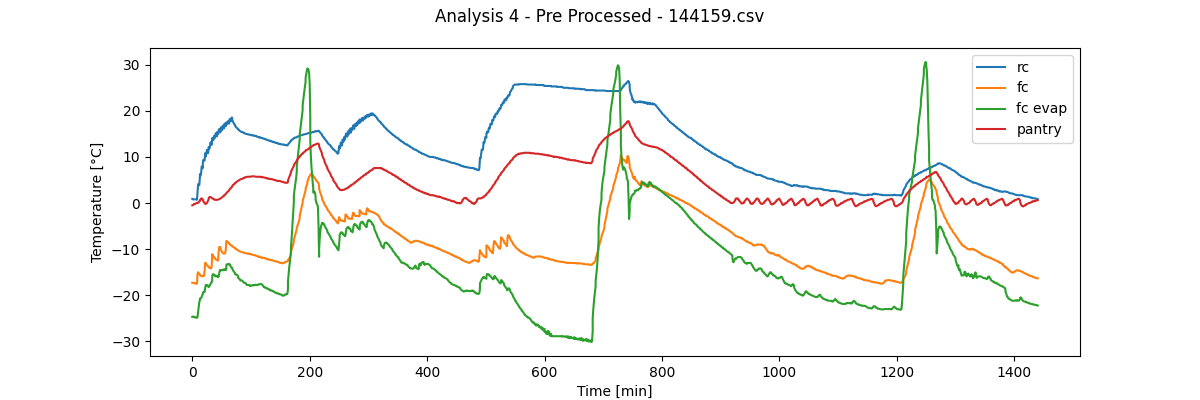

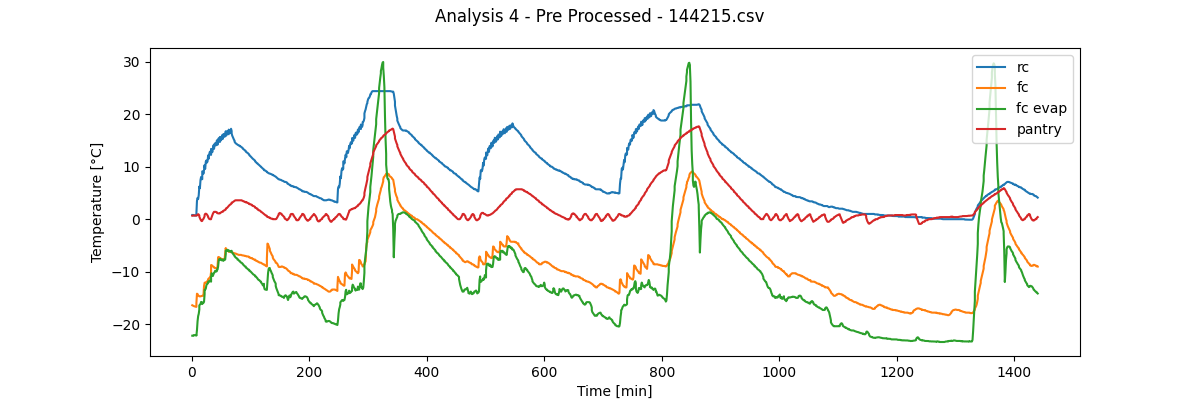

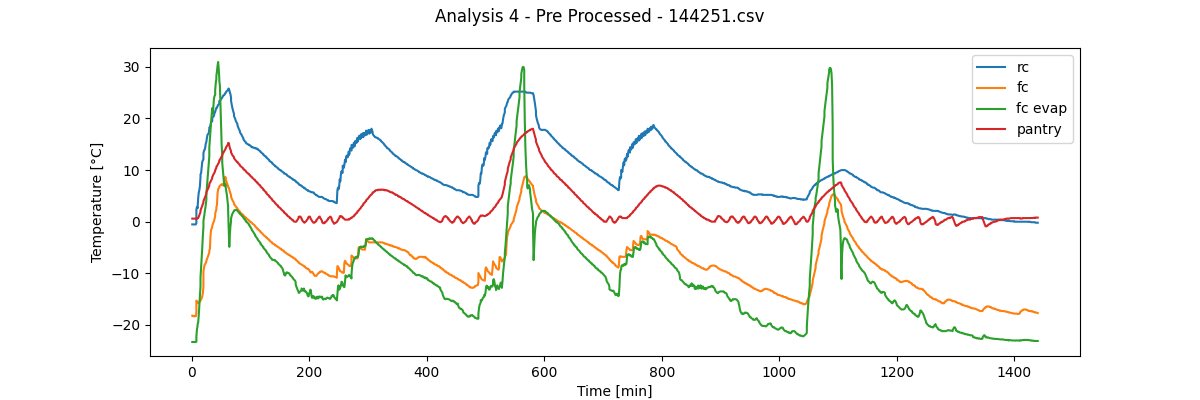

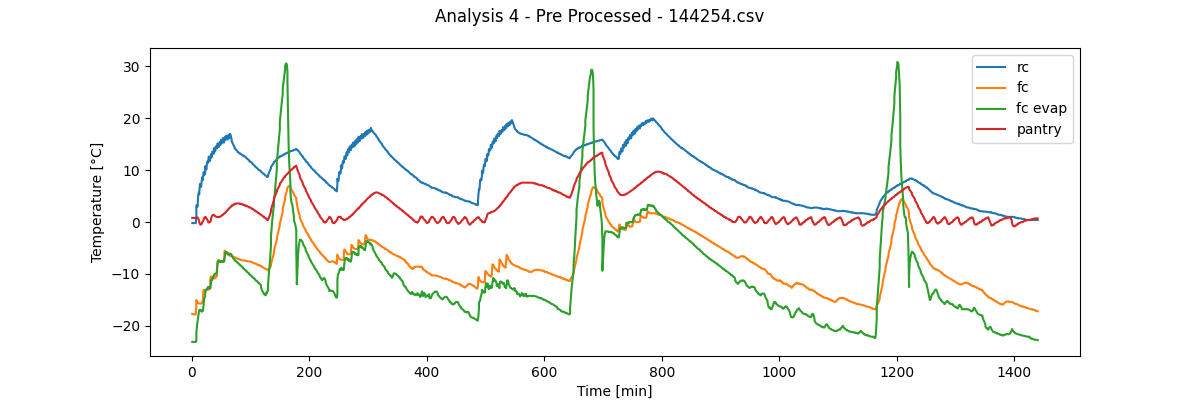

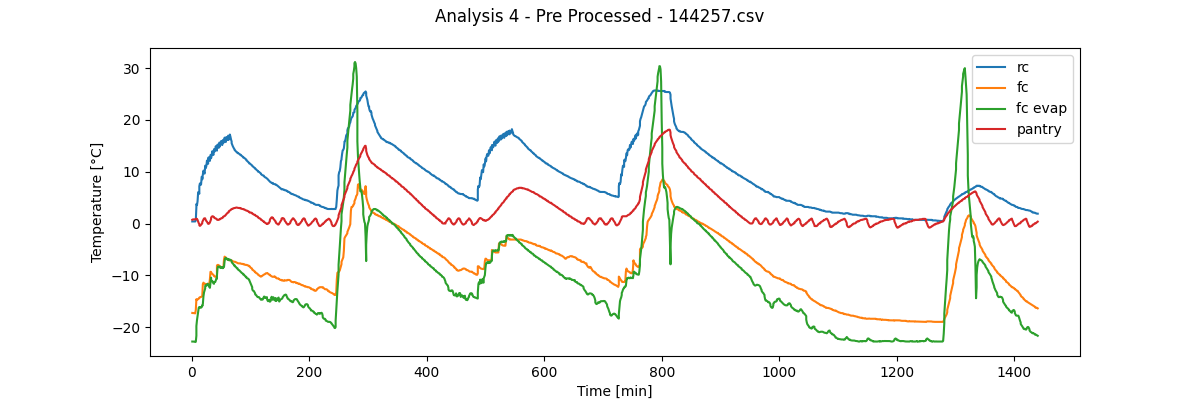

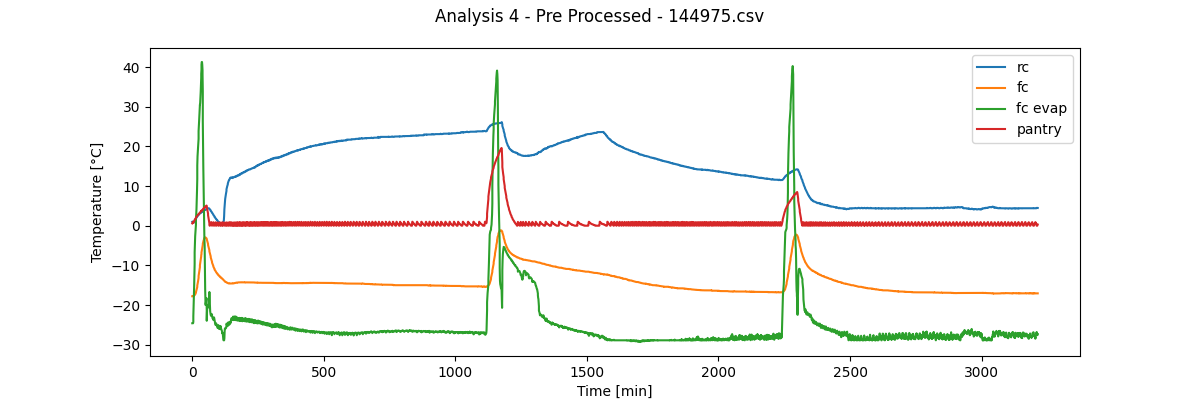

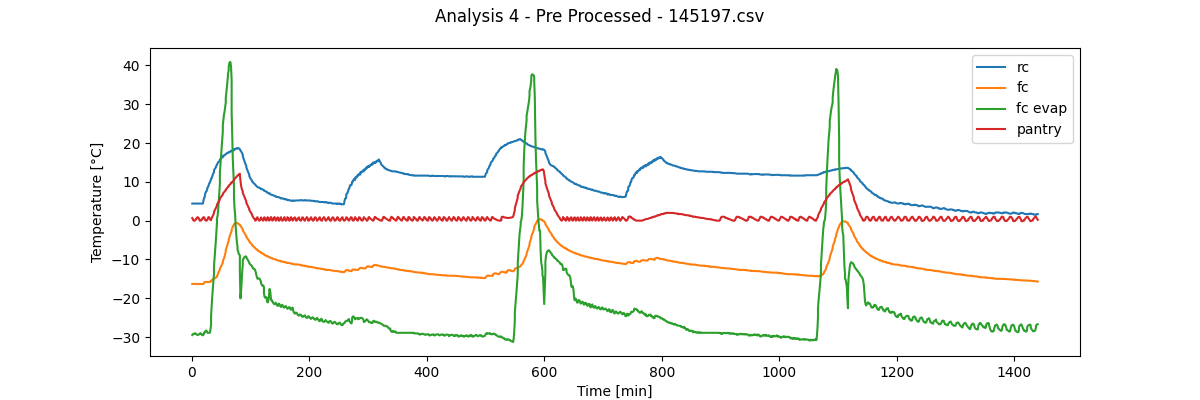

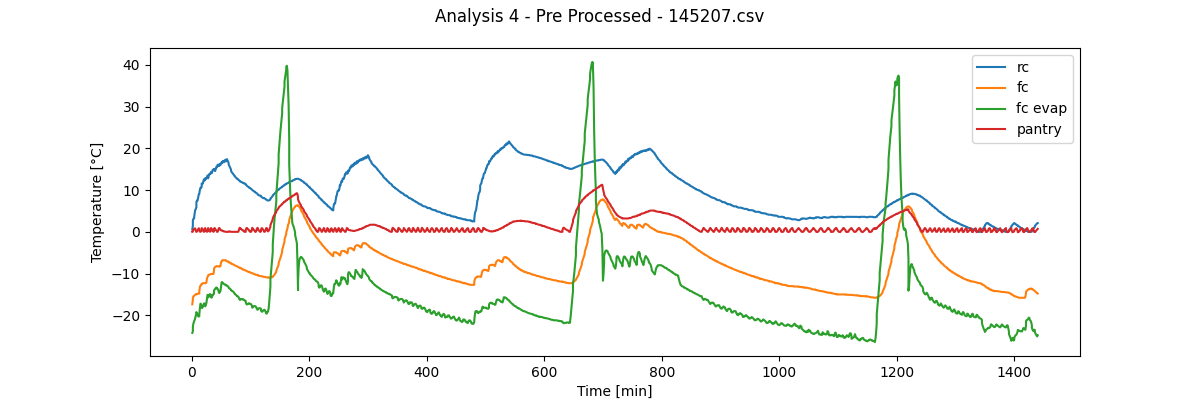

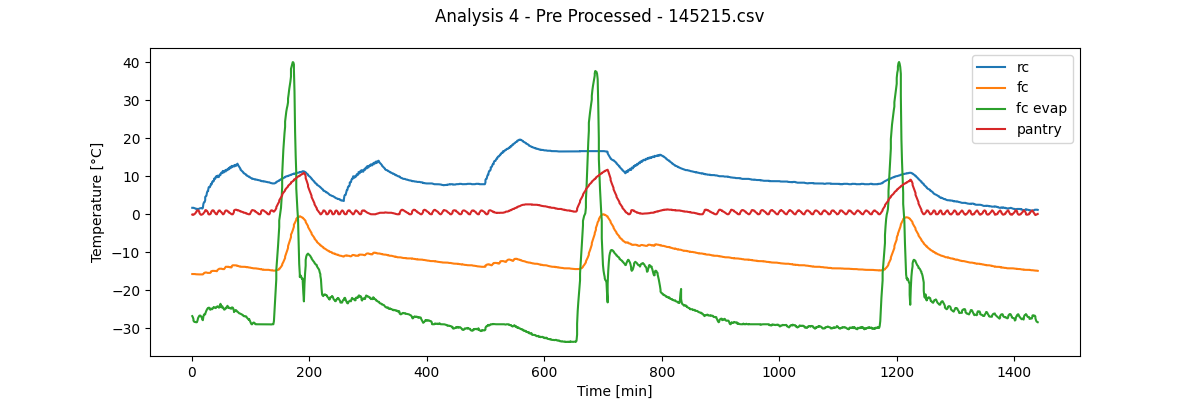

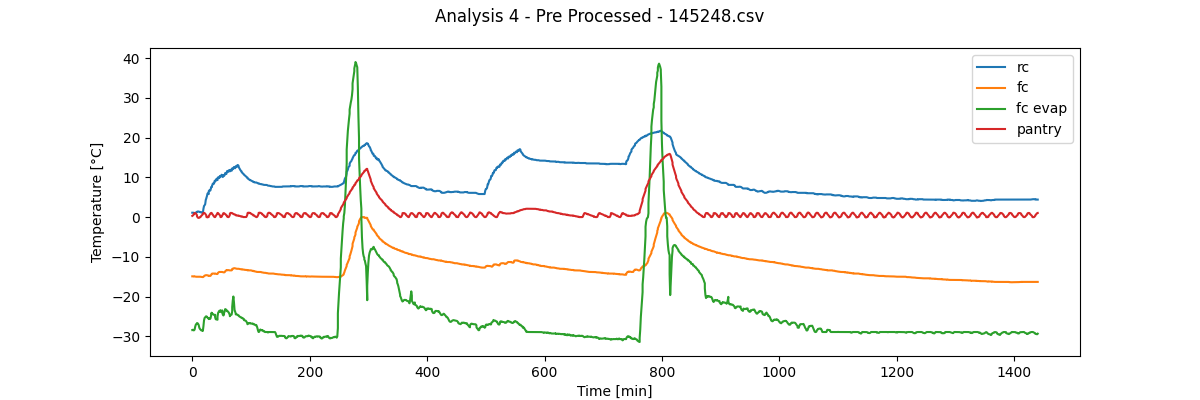

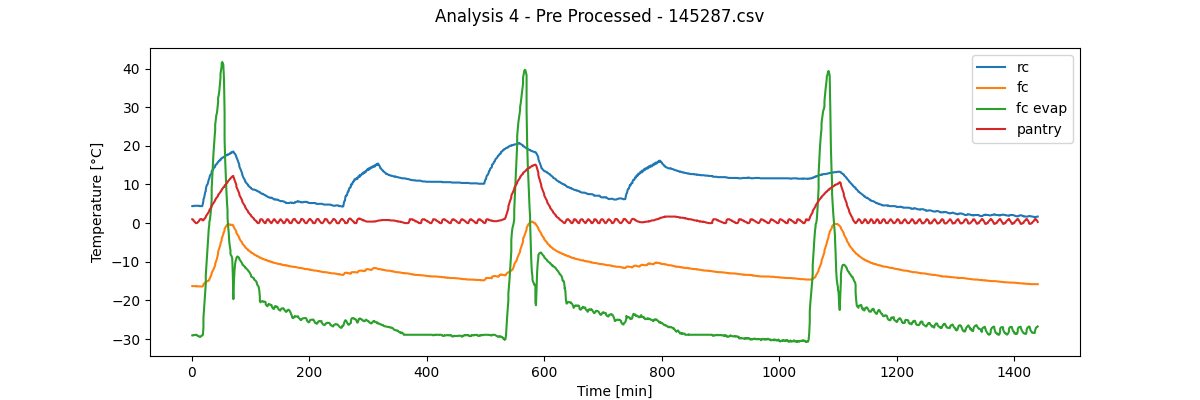

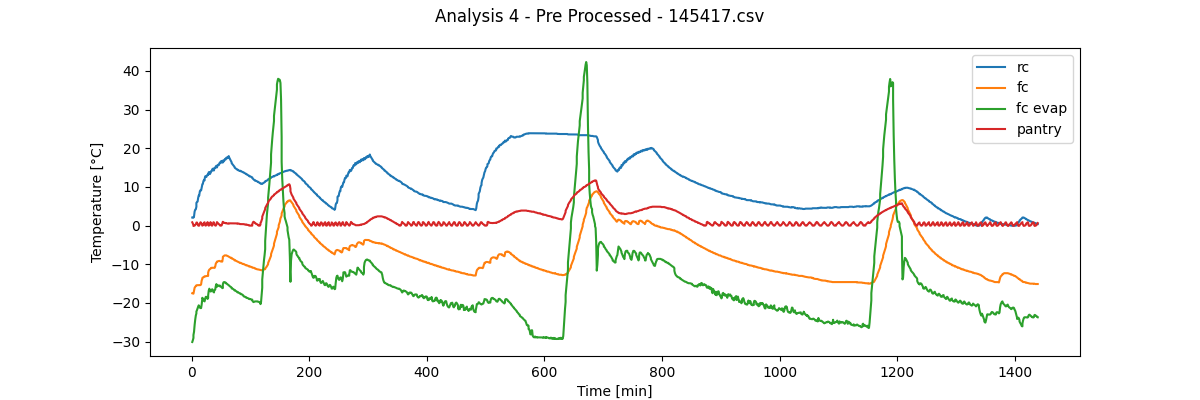

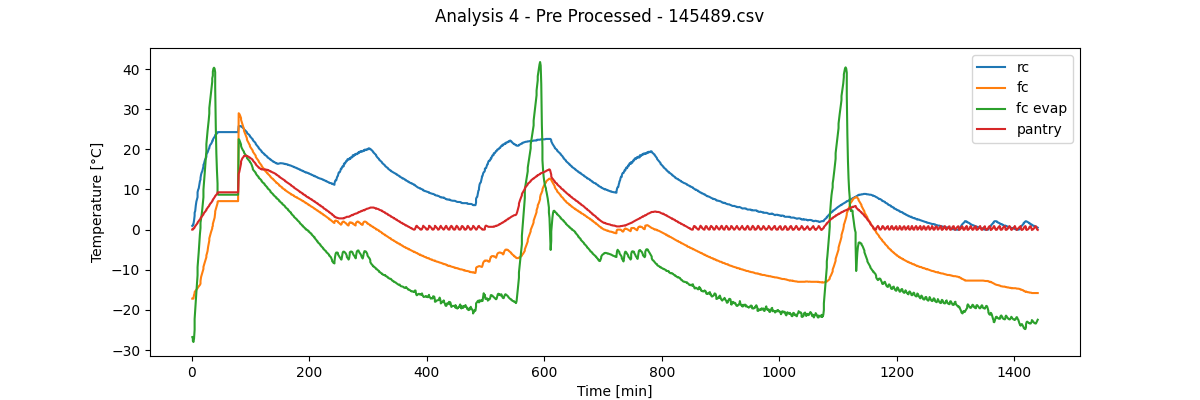

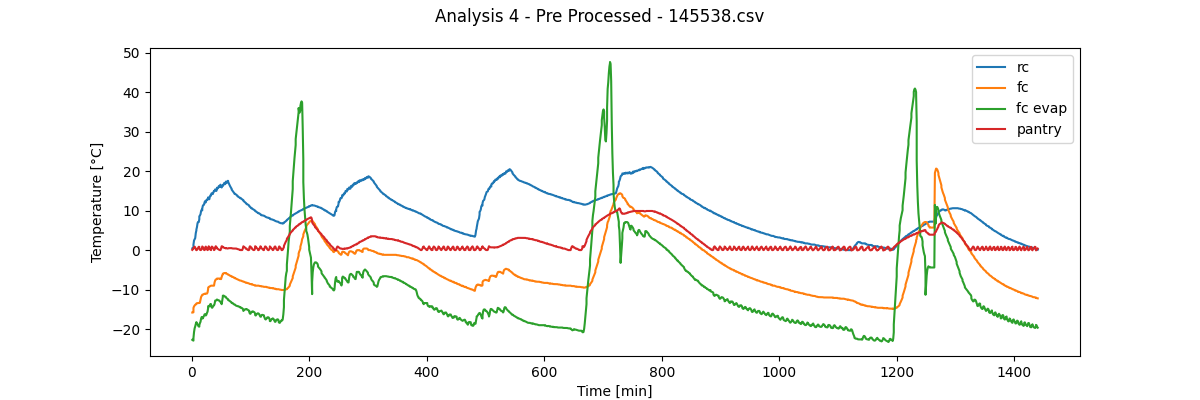

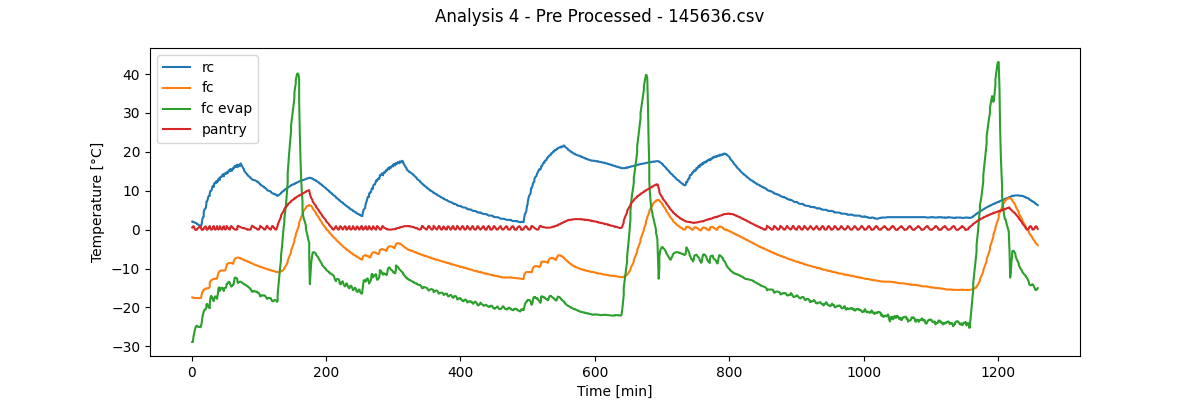

In [7]:
analysis4 = logs_summary[logs_summary['rc_mean'] > 9]['Log Name']

for log_to_analyze in analysis4:
    RefriPlot_PlotTemperature(csv_files[log_to_analyze],"Analysis 4 - " + log_to_analyze)
    Logs_Manual_Label[log_to_analyze] = "Door Open"

## 4 Using clustering methods

